In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PRISM_PATH = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism"
STRATEGY_PATH = "/home/paul/Documents/probabilistic_games/adv.tra"
STORE_PATH = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/"

In [3]:
from journepy.src.preprocessing.bpic17 import preprocessed_log
from journepy.src.alergia_utils import convert_utils

import probabilistic_game_utils as pgu 
#from src import game_construction
#from src import game_operations

from aalpy.learning_algs import run_Alergia
from aalpy.utils import save_automaton_to_file
from IPython.display import Image
from aalpy.utils import mdp_2_prism_format


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pm4py.objects.log.util import dataframe_utils

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

import json

import networkx as nx

import subprocess

import numpy as np
import copy

# Load Data
We load the event log and additionally needed information.

In [4]:
filtered_log_before, filtered_log_after = preprocessed_log("data/BPI Challenge 2017.xes") # uses common preprocessing

/home/paul/.local/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/home/paul/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:59<00:00, 528.40it/s]


In [5]:
print(len(filtered_log_before))
print(len(filtered_log_after))

5515
6989


In [6]:
# change from xes format
def parse(s):
    return s.replace('(', ')').replace(')', '').replace(' ', '')
filtered_log_before_activities = [[parse(e['concept:name']) for e in t] for t in filtered_log_before]
filtered_log_after_activities = [[parse(e['concept:name']) for e in t] for t in filtered_log_after]

[['start',
  'A_CreateApplication',
  'A_Submitted',
  'A_Concept',
  'A_Accepted',
  'O_CreateOffer0',
  'O_Sentmailandonline',
  'W_CallafteroffersSHORT',
  'A_Validating',
  'O_Returned',
  'W_CallincompletefilesSHORT',
  'A_Validating',
  'O_Accepted',
  'A_Pending',
  'positive'],
 ['start',
  'A_CreateApplication',
  'A_Submitted',
  'A_Concept',
  'A_Accepted',
  'O_CreateOffer0',
  'O_Sentmailandonline',
  'W_CallafteroffersSHORT',
  'A_Validating',
  'O_Returned',
  'W_CallincompletefilesSHORT',
  'A_Validating',
  'O_Accepted',
  'A_Pending',
  'positive'],
 ['start',
  'A_CreateApplication',
  'A_Submitted',
  'A_Concept',
  'A_Accepted',
  'O_CreateOffer0',
  'O_Sentmailandonline',
  'W_CallafteroffersSHORT',
  'A_Validating',
  'O_Returned',
  'W_CallincompletefilesSHORT',
  'A_Validating',
  'O_Accepted',
  'A_Pending',
  'positive'],
 ['start',
  'A_CreateApplication',
  'A_Submitted',
  'A_Concept',
  'A_Accepted',
  'O_CreateOffer0',
  'O_Sentmailandonline',
  'W_Calla

In [7]:
# load actor mapping: maps events to an actor (service provider or user)
with open('data/activities.xml') as f:
    data = f.read()
actors = json.loads(data)
actors = {parse(k) : parse(actors[k]) for k in actors}

In [8]:
# build action mapping: assigns each event to an actor
actions_to_activities = {}
actions_observed = set()
for trace in filtered_log_before_activities:
    actions_observed.update(trace)

actors_observed_actions = {}
for action in actions_observed:
    contained = [a for a in actors if a in action]
    print(action, contained)
    assert len(contained) == 1# each once - skip enumerating
    if actors[contained[0]] == "company": # events where company is NOT deterministic
        if 'O_Sentonlineonly' in action or 'O_Sentmailandonline' in action: # todo: might be quite realistic? 
            # sent online vs sent mail seems to be critical interaction - if aggregated together and diff. from tohers- 90%
            actions_to_activities[action] = "sent"
        elif 'O_CreateOffer0' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer1' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer2' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer3' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer4' in action:
            actions_to_activities[action] = action
        elif 'O_CreateOffer5' in action:
            actions_to_activities[action] = action
        elif 'A_Denied' in action:
            actions_to_activities[action] = action
        elif 'A_Incomplete' in action:
            actions_to_activities[action] = action
        elif 'A_Validating' in action:
            actions_to_activities[action] = action
        else:
            actions_to_activities[action] = action
    else:
        if "A_Submitted" in action: # events where user is deterministic
            actions_to_activities[action] = action
        elif "Callafteroffers" in action: # events where user is deterministic
            actions_to_activities[action] = "call"
        elif "Callincomplete" in action: # events where user is deterministic
            actions_to_activities[action] = "call"
        else: # includes "negative" action
            actions_to_activities[action] = "user"

    actors_observed_actions[action] = actors[contained[0]]

print(actors_observed_actions)
actors_observed_actions['offer'] = 'company'
actors_observed_actions['company'] = 'company'
actors_observed_actions['user'] = 'customer'
actors_observed_actions['sent'] = 'company'
actors_observed_actions['offer_response'] = 'company'
actors_observed_actions['callafter'] = 'customer'
actors_observed_actions['callincomplete'] = 'customer'

start ['start']
positive ['positive']
W_CallincompletefilesLONG ['W_Callincompletefiles']
O_Accepted ['O_Accepted']
TIMEOUT ['TIMEOUT']
O_CreateOffer1 ['O_CreateOffer']
A_CreateApplication ['A_CreateApplication']
O_Cancelled ['O_Cancelled']
W_CallafteroffersSUPERLONG ['W_Callafteroffers']
A_Concept ['A_Concept']
W_CallafteroffersLONG ['W_Callafteroffers']
O_Returned ['O_Returned']
A_Accepted ['A_Accepted']
A_Submitted ['A_Submitted']
W_CallincompletefilesSUPERLONG ['W_Callincompletefiles']
O_Sentmailandonline ['O_Sentmailandonline']
A_Validating ['A_Validating']
W_CallincompletefilesSHORT ['W_Callincompletefiles']
A_CancelledCUSTOMER ['A_CancelledCUSTOMER']
O_Sentonlineonly ['O_Sentonlineonly']
W_CallafteroffersSHORT ['W_Callafteroffers']
negative ['negative']
O_CreateOffer2 ['O_CreateOffer']
O_CreateOffer0 ['O_CreateOffer']
A_Pending ['A_Pending']
O_CreateOffer3 ['O_CreateOffer']
{'start': 'customer', 'positive': 'customer', 'W_CallincompletefilesLONG': 'customer', 'O_Accepted': 'cust

## Passive automata learning
The event log is transformed into an Input/Output format and environment actions to select the next player are added additionally.
Alergia learning automatically selects IO/Alergia if input is in [O, (I,O), ...] format.

In [9]:
# add activities
data_before = [[(actions_to_activities[t[i]], t[i]) for i in range(1, len(t))] for t in filtered_log_before_activities]
for d in data_before:
    d.insert(0, 'start')

data_after = [[(actions_to_activities[t[i]], t[i]) for i in range(1, len(t))] for t in filtered_log_after_activities]
for d in data_after:
    d.insert(0, 'start')

[['start',
  ('A_CreateApplication', 'A_CreateApplication'),
  ('A_Submitted', 'A_Submitted'),
  ('A_Concept', 'A_Concept'),
  ('A_Accepted', 'A_Accepted'),
  ('O_CreateOffer0', 'O_CreateOffer0'),
  ('sent', 'O_Sentmailandonline'),
  ('call', 'W_CallafteroffersSHORT'),
  ('user', 'TIMEOUT'),
  ('user', 'negative')],
 ['start',
  ('A_CreateApplication', 'A_CreateApplication'),
  ('A_Submitted', 'A_Submitted'),
  ('A_Concept', 'A_Concept'),
  ('A_Accepted', 'A_Accepted'),
  ('O_CreateOffer0', 'O_CreateOffer0'),
  ('sent', 'O_Sentmailandonline'),
  ('user', 'TIMEOUT'),
  ('user', 'negative')],
 ['start',
  ('A_CreateApplication', 'A_CreateApplication'),
  ('A_Submitted', 'A_Submitted'),
  ('A_Concept', 'A_Concept'),
  ('A_Accepted', 'A_Accepted'),
  ('O_CreateOffer0', 'O_CreateOffer0'),
  ('sent', 'O_Sentmailandonline'),
  ('call', 'W_CallafteroffersSHORT'),
  ('user', 'TIMEOUT'),
  ('user', 'negative')],
 ['start',
  ('A_CreateApplication', 'A_CreateApplication'),
  ('A_Submitted', 'A_Su

In [10]:
# model_before = run_Alergia(data_before, automaton_type='mdp', eps=0.9999, print_info=True)

# filename = "out/bpic_17-1"
# save_automaton_to_file(model_before, f"{filename}.dot")
# save_automaton_to_file(model_before, f"{filename}.png", file_type="png")

In [11]:
# quantify environment -> becomes MDP, could leave some non-det? -> look into def in paper
data_before_environment = []
for trace in data_before:
    current = [trace[0]]
    for i in range(1, len(trace)):
        e = trace[i]
        previous_state = "start" if i == 1 else trace[i-1][1]
        #print(d[i-1])
        # encode environment with following decision
        #current.append(('environment', "environment"+ previous_state))
        #current.append(("environment"+ previous_state, d[i][0]+previous_state))
        
        # encode decision in one step
        current.append(('env', actors_observed_actions[e[1]] + previous_state))
        current.append(e)
    data_before_environment.append(current)

data_after_environment = []
for trace in data_after:
    current = [trace[0]]
    for i in range(1, len(trace)):
        e = trace[i]
        previous_state = "start" if i == 1 else trace[i-1][1]
        #print(d[i-1])
        # encode environment with following decision
        #current.append(('environment', "environment"+ previous_state))
        #current.append(("environment"+ previous_state, d[i][0]+previous_state))
        
        # encode decision in one step
        current.append(('env', actors_observed_actions[e[1]] + previous_state))
        current.append(e)
    data_after_environment.append(current)

data_after_environment

[['start',
  ('env', 'companystart'),
  ('A_CreateApplication', 'A_CreateApplication'),
  ('env', 'customerA_CreateApplication'),
  ('A_Submitted', 'A_Submitted'),
  ('env', 'companyA_Submitted'),
  ('A_Concept', 'A_Concept'),
  ('env', 'companyA_Concept'),
  ('A_Accepted', 'A_Accepted'),
  ('env', 'companyA_Accepted'),
  ('O_CreateOffer0', 'O_CreateOffer0'),
  ('env', 'companyO_CreateOffer0'),
  ('sent', 'O_Sentmailandonline'),
  ('env', 'customerO_Sentmailandonline'),
  ('call', 'W_CallafteroffersSHORT'),
  ('env', 'customerW_CallafteroffersSHORT'),
  ('user', 'TIMEOUT'),
  ('env', 'customerTIMEOUT'),
  ('user', 'negative')],
 ['start',
  ('env', 'companystart'),
  ('A_CreateApplication', 'A_CreateApplication'),
  ('env', 'customerA_CreateApplication'),
  ('A_Submitted', 'A_Submitted'),
  ('env', 'companyA_Submitted'),
  ('A_Concept', 'A_Concept'),
  ('env', 'companyA_Concept'),
  ('A_Accepted', 'A_Accepted'),
  ('env', 'companyA_Accepted'),
  ('O_CreateOffer0', 'O_CreateOffer0'),
  

In [12]:
model_before_environment = run_Alergia(data_before_environment, automaton_type='mdp', eps=0.8, print_info=True) # 0.1 plot interesting, 0.8 is confirms knowledge, 1.2 : plot align, 2 grows stronger, 1.8 : 2 is worse, grows stronger, gas is bit more interesting
model_after_environment = run_Alergia(data_after_environment, automaton_type='mdp', eps=0.8, print_info=True)

PTA Construction Time:  0.08
Alergia Learning Time: 0.08
Alergia Learned 95 state automaton.
PTA Construction Time:  0.09
Alergia Learning Time: 0.22
Alergia Learned 131 state automaton.


In [13]:
filename = "out/bpic_17-1_environment_actions"
save_automaton_to_file(model_before_environment, f"{filename}.dot")
save_automaton_to_file(model_before_environment, f"{filename}.png", file_type="png")

Model saved to out/bpic_17-1_environment_actions.dot.
Model saved to out/bpic_17-1_environment_actions.png.


In [14]:
filename = "out/bpic_17-2_environment_actions"
save_automaton_to_file(model_after_environment, f"{filename}.dot")
#save_automaton_to_file(model_after_environment, f"{filename}.png", file_type="png")

Model saved to out/bpic_17-2_environment_actions.dot.


In [15]:
g_before = convert_utils.mdp_to_nx(model_before_environment, actors_observed_actions)
g_after = convert_utils.mdp_to_nx(model_after_environment, actors_observed_actions)

source: q0: start
for action: env
reaching state q1: companystart
with prob: 1.0
is controllable False
source: q1: companystart
for action: A_CreateApplication
reaching state q2: A_CreateApplication
with prob: 1.0
is controllable True
source: q2: A_CreateApplication
for action: env
reaching state q4: customerA_CreateApplication
with prob: 0.6407978241160471
is controllable False
reaching state q3: companyA_CreateApplication
with prob: 0.35920217588395287
is controllable False
source: q3: companyA_CreateApplication
for action: A_Concept
reaching state q5: A_Concept
with prob: 1.0
is controllable True
source: q4: customerA_CreateApplication
for action: A_Submitted
reaching state q6: A_Submitted
with prob: 1.0
is controllable False
source: q5: A_Concept
for action: env
reaching state q7: companyA_Concept
with prob: 1.0
is controllable False
source: q6: A_Submitted
for action: env
reaching state q8: companyA_Submitted
with prob: 1.0
is controllable False
source: q7: companyA_Concept
for ac

In [16]:
g_before = pgu.add_gas_and_user_count(g_before, data_before_environment)
g_after = pgu.add_gas_and_user_count(g_after, data_after_environment)

('q0: start', 'q1: companystart') {'action': 'env', 'prob_weight': 1.0, 'controllable': False, 'count': 5515, 'gas': -4.242426659410384, 'trace_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 

In [17]:
print(len(list(nx.simple_cycles(g_before))))
print(len(list(nx.simple_cycles(g_after))))

646
174


In [18]:
print(g_before.nodes())

['q0: start', 'q1: companystart', 'q2: A_CreateApplication', 'q4: customerA_CreateApplication', 'q3: companyA_CreateApplication', 'q5: A_Concept', 'q6: A_Submitted', 'q7: companyA_Concept', 'q8: companyA_Submitted', 'q9: A_Accepted', 'q10: A_Concept', 'q11: companyA_Accepted', 'q12: companyA_Concept', 'q13: O_CreateOffer0', 'q14: A_Accepted', 'q15: companyO_CreateOffer0', 'q16: customerO_CreateOffer0', 'q17: companyA_Accepted', 'q19: O_Sentmailandonline', 'q20: O_Sentonlineonly', 'q18: O_CreateOffer1', 'q21: A_CancelledCUSTOMER', 'q22: O_Cancelled', 'q23: O_CreateOffer0', 'q24: companyO_CreateOffer1', 'q54: customerO_CreateOffer1', 'q26: customerO_Sentmailandonline', 'q25: companyO_Sentmailandonline', 'q28: customerO_Sentonlineonly', 'q27: companyO_Sentonlineonly', 'q29: customerA_CancelledCUSTOMER', 'q30: companyO_Cancelled', 'q68: customerO_Cancelled', 'q31: companyO_CreateOffer0', 'q33: O_Sentmailandonline', 'q32: O_CreateOffer2', 'q34: A_Validating', 'q35: O_CreateOffer1', 'q42: O_

In [19]:
# test on deterministic cycles:
def assert_no_det_cycle(g):
    for c in list(nx.simple_cycles(g)):
        found = False
        for i in range(len(c)):
            if g[c[i]][c[(i+1)%len(c)]]['prob_weight'] != 1:
                print(g[c[i]][c[(i+1)%len(c)]]['prob_weight'])
                found = True
        assert found
        print()
assert_no_det_cycle(g_before)
assert_no_det_cycle(g_after)

0.010638297872340425
0.7575757575757576
0.13043478260869565
0.3548387096774194
0.01675977653631285
0.78125
0.055248618784530384
0.01141552511415525
0.6453804347826086

0.010638297872340425
0.7575757575757576
0.13043478260869565
0.3548387096774194
0.01675977653631285
0.78125
0.055248618784530384
0.8996941896024465
0.6453804347826086

0.010638297872340425
0.7575757575757576
0.13043478260869565
0.3548387096774194
0.01675977653631285
0.78125
0.9447513812154696
0.07810750279955207
0.7912371134020618
0.01141552511415525
0.6453804347826086

0.010638297872340425
0.7575757575757576
0.13043478260869565
0.3548387096774194
0.01675977653631285
0.78125
0.9447513812154696
0.07810750279955207
0.7912371134020618
0.8996941896024465
0.6453804347826086

0.010638297872340425
0.7575757575757576
0.13043478260869565
0.3548387096774194
0.01675977653631285
0.78125
0.9447513812154696
0.07810750279955207

0.010638297872340425
0.7575757575757576
0.13043478260869565
0.3548387096774194
0.01675977653631285
0.78125
0.

In [20]:
# available actions
action_lists = []
for s in g_before:
    actions = []
    for t in g_before[s]:
        actions.append(g_before.edges[(s,t)]['action'])
    print(set(actions), len(list(g_before[s])))
    action_lists.append(set(actions))
print(action_lists)

{'env'} 1
{'A_CreateApplication'} 1
{'env'} 2
{'A_Submitted'} 1
{'A_Concept'} 1
{'env'} 1
{'env'} 1
{'A_Accepted'} 1
{'A_Concept'} 1
{'env'} 1
{'env'} 1
{'O_CreateOffer0'} 1
{'A_Accepted'} 1
{'env'} 2
{'env'} 1
{'O_CreateOffer1', 'sent'} 3
{'user'} 2
{'O_CreateOffer0'} 1
{'env'} 2
{'env'} 2
{'env'} 2
{'env'} 1
{'env'} 2
{'env'} 2
{'O_CreateOffer2', 'sent'} 2
{'user'} 1
{'call', 'user'} 6
{'A_Validating', 'O_CreateOffer1', 'O_CreateOffer2', 'sent', 'O_CreateOffer3'} 5
{'call', 'user'} 3
{'A_Validating'} 1
{'user'} 1
{'O_CreateOffer1', 'O_CreateOffer2', 'sent'} 3
{'user'} 2
{'O_CreateOffer1', 'sent'} 3
{'env'} 2
{'env'} 1
{'env'} 1
{'env'} 1
{'env'} 2
{'env'} 1
{'env'} 2
{'env'} 2
{'env'} 2
{'env'} 1
{'env'} 1
{'env'} 1
set() 0
{'env'} 2
{'sent', 'O_CreateOffer3'} 2
{'O_Returned'} 1
{'sent'} 2
{'O_CreateOffer1', 'A_Validating', 'O_CreateOffer2'} 3
{'user'} 3
{'O_CreateOffer1', 'A_Validating', 'O_CreateOffer2'} 3
{'user'} 3
{'user'} 2
{'A_Validating'} 1
{'user'} 1
{'user'} 2
{'call', 'use

# Write to prism

In [21]:
from journepy.src.mc_utils.prism_utils import PrismPrinter
from journepy.src.mc_utils.prism_utils import PrismQuery

In [22]:
printer_before = PrismPrinter(g_before, STORE_PATH, "bpic_17_1_alergia.prism")
printer_before.write_to_prism()
printer_after = PrismPrinter(g_after, STORE_PATH, "bpic_17_2_alergia.prism")
printer_after.write_to_prism()

In [23]:
print(g_before.nodes())
print(len(g_before.nodes()))

['q0: start', 'q1: companystart', 'q2: A_CreateApplication', 'q4: customerA_CreateApplication', 'q3: companyA_CreateApplication', 'q5: A_Concept', 'q6: A_Submitted', 'q7: companyA_Concept', 'q8: companyA_Submitted', 'q9: A_Accepted', 'q10: A_Concept', 'q11: companyA_Accepted', 'q12: companyA_Concept', 'q13: O_CreateOffer0', 'q14: A_Accepted', 'q15: companyO_CreateOffer0', 'q16: customerO_CreateOffer0', 'q17: companyA_Accepted', 'q19: O_Sentmailandonline', 'q20: O_Sentonlineonly', 'q18: O_CreateOffer1', 'q21: A_CancelledCUSTOMER', 'q22: O_Cancelled', 'q23: O_CreateOffer0', 'q24: companyO_CreateOffer1', 'q54: customerO_CreateOffer1', 'q26: customerO_Sentmailandonline', 'q25: companyO_Sentmailandonline', 'q28: customerO_Sentonlineonly', 'q27: companyO_Sentonlineonly', 'q29: customerA_CancelledCUSTOMER', 'q30: companyO_Cancelled', 'q68: customerO_Cancelled', 'q31: companyO_CreateOffer0', 'q33: O_Sentmailandonline', 'q32: O_CreateOffer2', 'q34: A_Validating', 'q35: O_CreateOffer1', 'q42: O_

In [24]:
source = [s for s in g_before if 'start' == s.split(' ')[1]]
target = [s for s in g_before if 'positive' in s]
assert len(source) == 1 and len(target) == 1
print(len(nx.shortest_path(g_before, source=source[0], target=target[0]))) # includes start and target -> # 19 interact.
# prism in exp. 20.6 (includes env. changes to do nothin)

21


In [25]:
query_before = PrismQuery(g_before, STORE_PATH, "bpic_17_1_alergia.prism", PRISM_PATH)
model_name_before = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism"

query_after = PrismQuery(g_after, STORE_PATH, "bpic_17_2_alergia.prism", PRISM_PATH)
model_name_after = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism"

In [26]:
results_file_before = query_before.query("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props", write_parameterized=True)
print(results_file_before['q0start'])

results_file_after = query_after.query("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props", write_parameterized=True)
print(results_file_after['q0start'])

0.8865074490124265
0.9166362285809062


In [27]:
subprocess.run([PRISM_PATH, model_name_before, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props", "-const", "envprob=0"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Tue Apr 23 17:34:35 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props -const envprob=0

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props"...

3 properties:
(1) <<providerPlayer,userPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(2) <<providerPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ F (positive|negative) ]

---------------------------------------------------------------------


CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props', '-const', 'envprob=0'], returncode=0)

In [28]:
subprocess.run([PRISM_PATH, model_name_after, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props", "-const", "envprob=0"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Tue Apr 23 17:34:36 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props -const envprob=0

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props"...

3 properties:
(1) <<providerPlayer,userPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(2) <<providerPlayer>>R{"gas_neg"}min=? [ F (positive|negative) ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ F (positive|negative) ]

---------------------------------------------------------------------


CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/mc_runs.props', '-const', 'envprob=0'], returncode=0)

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Tue Apr 23 22:40:46 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props -const 'envprob=-0.95:0.05:0.95' -exportresults '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/succ_prop_cond-bpic-17-1.txt:dataframe'

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props"...

1 property:
(1) <<providerPlayer>>Pmax=? [ F positive ]

---------------------------------------------------------------------

Model checking: <

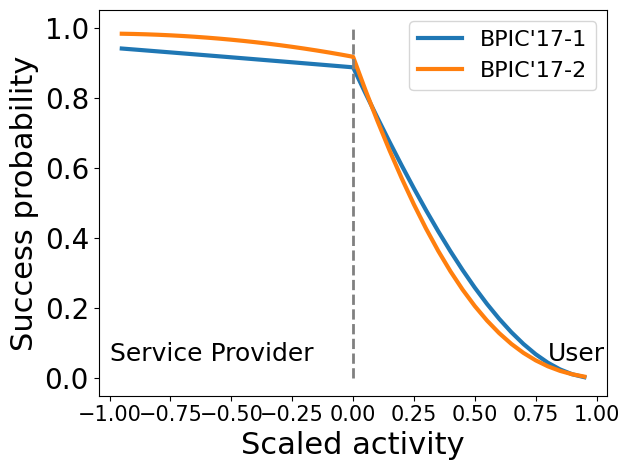

In [30]:
# run satisfiability result
import matplotlib.pyplot as plt

file_name = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/succ_prop_cond-bpic-17-1.txt"
subprocess.run([PRISM_PATH, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism", "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props", "-const", "envprob=-0.95:0.05:0.95", "-exportresults", file_name+":dataframe"]) 

df_visual = pd.read_csv(file_name)
plt.plot(df_visual['envprob'], df_visual['Result'], label = "BPIC'17-1", linewidth=3)

file_name = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/succ_prop_cond-bpic-17-2.txt"
subprocess.run([PRISM_PATH, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism", "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props", "-const", "envprob=-0.95:0.05:0.95", "-exportresults", file_name+":dataframe"]) 

df_visual = pd.read_csv(file_name)
plt.plot(df_visual['envprob'], df_visual['Result'], label = "BPIC'17-2", linewidth=3)

plt.vlines(x=0, ymin=0, ymax = 1, linewidth=2, color = 'grey', linestyles='--')
plt.text(-1, 0.05, 'Service Provider', fontsize = 18)
plt.text(0.8, 0.05, 'User', fontsize = 18)
plt.legend(fontsize=16)
plt.xlabel("Scaled activity", fontsize=22)
plt.ylabel("Success probability", fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("out/bpic_activity_comparison.png", dpi=300)
plt.show()

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Fri Apr 19 11:21:33 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/reward_props.props -prop 3 -const 'm0=0,m1=0:1:80,m2=0,' -exportresults '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/steps_gas_pos_bound-bpic-17-1.txt:dataframe'

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/reward_props.props"...

4 properties:
(1) <<providerPlayer>>Pmax=? [ F positive ]
(2) <<providerPlayer>>(((R{"gas_pos"}>=m0 [ C<=m1 ]&R{"gas_neg"}<=m2 [ C<=m

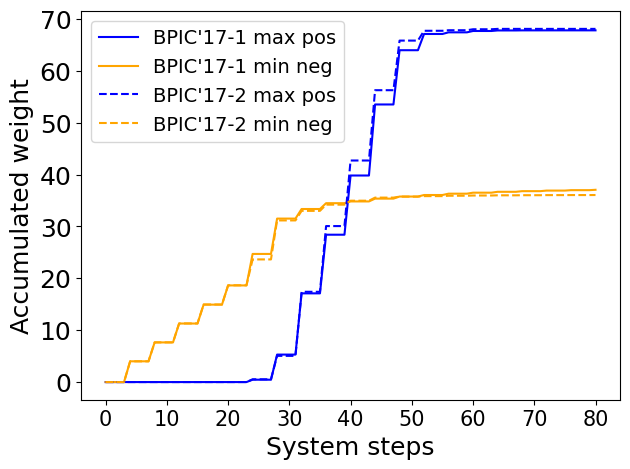

In [30]:
# run gas upper and lower bound
PrismPrinter(g_before, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/", "bpic_17_1_alergia.prism").write_to_prism(write_extended_parameterized=True)
file_name_pos = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/steps_gas_pos_bound-bpic-17-1.txt"
subprocess.run([PRISM_PATH, model_name_before, 
                "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/reward_props.props", "-prop", "3",
                "-const", "m0=0,m1=0:1:80,m2=0,", "-exportresults", file_name_pos+":dataframe"]) 
file_name_neg = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/steps_gas_neg_bound-bpic-17-1.txt"
subprocess.run([PRISM_PATH, model_name_before, 
                "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/reward_props.props", "-prop", "4",
                "-const", "m0=0,m1=0:1:80,m2=0,", "-exportresults", file_name_neg+":dataframe"]) 

df_visual = pd.read_csv(file_name_pos)
plt.plot(df_visual['m1'], df_visual['Result'], label="BPIC'17-1 max pos", c = "blue")
df_visual = pd.read_csv(file_name_neg)
plt.plot(df_visual['m1'], df_visual['Result'], label="BPIC'17-1 min neg", c = "orange")

PrismPrinter(g_after, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/", "bpic_17_2_alergia.prism").write_to_prism(write_extended_parameterized=True)
file_name_pos = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/steps_gas_pos_bound-bpic-17-2.txt"
subprocess.run([PRISM_PATH, model_name_after, 
                "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/reward_props.props", "-prop", "3",
                "-const", "m0=0,m1=0:1:80,m2=0,", "-exportresults", file_name_pos+":dataframe"]) 
file_name_neg = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/steps_gas_neg_bound-bpic-17-2.txt"
subprocess.run([PRISM_PATH, model_name_after, 
                "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/reward_props.props", "-prop", "4",
                "-const", "m0=0,m1=0:1:80,m2=0,", "-exportresults", file_name_neg+":dataframe"]) 

df_visual = pd.read_csv(file_name_pos)
plt.plot(df_visual['m1'], df_visual['Result'], label="BPIC'17-2 max pos", c = "blue", linestyle="dashed")
df_visual = pd.read_csv(file_name_neg)
plt.plot(df_visual['m1'], df_visual['Result'], label="BPIC'17-2 min neg", c = "orange", linestyle="dashed")

plt.legend(fontsize=14)
plt.xlabel("System steps", fontsize=18)
plt.ylabel("Accumulated weight", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("out/bpic_17-1_steps.png", dpi=300)
plt.show()

In [31]:
query_before = PrismQuery(g_before, STORE_PATH, "bpic_17_1_alergia.prism", PRISM_PATH)
query_after = PrismQuery(g_after, STORE_PATH, "bpic_17_2_alergia.prism", PRISM_PATH)

In [32]:
strategy_before = query_before.get_strategy("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props")

['0', 'n0_0', '1', 'n1_0', '2', 'n2_0', '3', 'n3_0', '4', 'n4_0', '5', 'n5_0', '6', 'n6_0', '7', 'n7_0', '8', 'n8_0', '9', 'n9_0', '10', 'n10_0', '11', 'n11_0', '12', 'n12_0', '13', 'n13_0', '14', 'n14_0', '15', 'n15_0', '16', 'n16_0', '17', 'n17_0', '18', 'n18_0', '19', 'n19_0', '20', 'n20_0', '21', 'n21_0', '22', 'n22_0', '23', 'n23_0', '24', 'n24_0', '25', 'n25_0', '26', 'n26_0', '27', 'n27_0', '28', 'n28_0', '29', 'n29_0', '30', 'n30_0', '31', 'n31_0', '32', 'n32_0', '33', 'n33_0', '34', 'n34_0', '35', 'n35_0', '36', 'n36_0', '37', 'n37_0', '38', 'n38_0', '39', 'n39_0', '40', 'n40_0', '41', 'n41_0', '42', 'n42_0', '43', 'n43_0', '44', 'n44_0', '45', 'n45_0', '46', 'n46_0', '47', 'n47_0', '48', 'n48_0', '49', 'n49_0', '50', 'n50_0', '51', 'n51_0', '52', 'n52_0', '53', 'n53_0', '54', 'n54_0', '55', 'n55_0', '56', 'n56_0', '57', 'n57_0', '58', 'n58_0', '59', 'n59_0', '60', 'n60_0', '61', 'n61_0', '62', 'n62_0', '63', 'n63_0', '64', 'n64_0', '65', 'n65_0', '66', 'n66_0', '67', 'n67_0',

In [33]:
strategy_after = query_after.get_strategy("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props")

['0', 'n0_0', '1', 'n1_0', '2', 'n2_0', '3', 'n3_0', '4', 'n4_0', '5', 'n5_0', '6', 'n6_0', '7', 'n7_0', '8', 'n8_0', '9', 'n9_0', '10', 'n10_0', '11', 'n11_0', '12', 'n12_0', '13', 'n13_0', '14', 'n14_0', '15', 'n15_0', '16', 'n16_0', '17', 'n17_0', '18', 'n18_0', '19', 'n19_0', '20', 'n20_0', '21', 'n21_0', '22', 'n22_0', '23', 'n23_0', '24', 'n24_0', '25', 'n25_0', '26', 'n26_0', '27', 'n27_0', '28', 'n28_0', '29', 'n29_0', '30', 'n30_0', '31', 'n31_0', '32', 'n32_0', '33', 'n33_0', '34', 'n34_0', '35', 'n35_0', '36', 'n36_0', '37', 'n37_0', '38', 'n38_0', '39', 'n39_0', '40', 'n40_0', '41', 'n41_0', '42', 'n42_0', '43', 'n43_0', '44', 'n44_0', '45', 'n45_0', '46', 'n46_0', '47', 'n47_0', '48', 'n48_0', '49', 'n49_0', '50', 'n50_0', '51', 'n51_0', '52', 'n52_0', '53', 'n53_0', '54', 'n54_0', '55', 'n55_0', '56', 'n56_0', '57', 'n57_0', '58', 'n58_0', '59', 'n59_0', '60', 'n60_0', '61', 'n61_0', '62', 'n62_0', '63', 'n63_0', '64', 'n64_0', '65', 'n65_0', '66', 'n66_0', '67', 'n67_0',

In [34]:
def can_be_merged(g, results_file):
    for s in g.nodes():
        reachable_values = [round(results_file[t],4) for t in g[s]]
        if round(results_file[s],4) in reachable_values:
        #if len(set(reachable_values)) == 1 and reachable_values[0] == round(results_file[s],2):
            return s 
    return None

"""
NOTE: One positive and one negative node is kept and all remaining from positive/negative cluster are merged into them.
"""
def reduce_graph(g, results_file):
    neg_cluster = []
    pos_cluster = []
    print("size start", len(g.nodes()))
    s = can_be_merged(g, results_file)
    while(s != None):
        for t in g[s]:
            if round(results_file[t],4) != round(results_file[s],4):
                continue
            g = nx.contracted_nodes(g, s, t, self_loops = False)
        s = can_be_merged(g, results_file)

    for s in g:
        if results_file[s] == 0:
            neg_cluster.append(s)
        if results_file[s] == 1:
            pos_cluster.append(s)
    for s in pos_cluster[1:]:
        g = nx.contracted_nodes(g, pos_cluster[0], s, self_loops=False)
    for s in neg_cluster[1:]:
        g = nx.contracted_nodes(g, neg_cluster[0], s, self_loops=False)



    g.remove_edges_from(nx.selfloop_edges(g))

    print("size reduced", len(g.nodes()))
    return g

In [35]:
from  matplotlib.colors import LinearSegmentedColormap # for color map
from matplotlib.colors import rgb2hex

def compute_color_map(g, results_file):
    c = ["darkred","gold","darkgreen"]
    v = [0,0.5,1]
    l = list(zip(v,c))
    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)
    s = cmap(0.23)
    map = {}
    for s in g.nodes():
        map[s] = rgb2hex(cmap(results_file[s])) # have to convert to hex color
    return map

def draw_dfg(g, name, names={}, layout = "sfdp", color_map = []):
    scaling = 10
    # build graph with variable thicknes
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)

    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        edge = A.get_edge(e[0], e[1])
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge.attr["style"] = "dotted"
                #edge.attr["label"] =  str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")

    for n in A.nodes():
        if n in names:
            new = names[n]
            if isinstance(names[n], float): 
                new = round(names[n], 2)
            n.attr['label'] = new
            #if new == 1:
            #    n.attr['label'] = "pos"
            #elif new == 0:
            #    n.attr['label'] = "neg"
            #else:
            #    n.attr["label"] = "" # uncomment to print state names
        if n in color_map:
            n.attr['color'] = color_map[n]
    
        n.attr['fontsize'] = 120
        n.attr['penwidth'] = 30
        n.attr['height'] = 3
        n.attr['width'] = 3

    #todo add color
    for e in A.edges():
        e.attr['penwidth'] = 20
        e.attr["fontsize"] = 120
        e.attr["label"] = str(round(g[e[0]][e[1]]["prob_weight"],2))
        e.attr["color"] = "black"

        if g[e[0]][e[1]]['gas'] > 0:
            e.attr["color"] ="darkgreen"
        if g[e[0]][e[1]]['gas'] < 0:
            e.attr["color"] ="red"
             
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    A.draw(name)
    print("Plotted", name)

In [36]:
# def get_probs_file(results_file, g, printer):
#     isomophism = nx.vf2pp_isomorphism(printer.g, g, node_label=None)
#     parsed_results_file = {isomophism[r] : results_file[r] for r in results_file}
#     return parsed_results_file

# print(g.nodes())
# color_map = compute_color_map(g, get_probs_file(results_file, g, printer))

# import copy 
# reduced_graph = copy.deepcopy(g)
# for s in g:
#     for t in g:
#         if ("C-"+extended_id_naming[s] == extended_id_naming[t] or "U-"+extended_id_naming[s] == extended_id_naming[t]):
#             reduced_graph = nx.contracted_nodes(reduced_graph, s, t, self_loops=False)

# draw_dfg(reduced_graph, "greps/greps_clustered.png", names=extended_id_naming, layout = "dot", color_map=color_map)


def get_probs_file(results_file, g, printer):
    isomophism = nx.vf2pp_isomorphism(printer.g, g, node_label=None)
    parsed_results_file = {isomophism[r] : results_file[r] for r in results_file}
    return parsed_results_file

print(g_before.nodes())
color_map = compute_color_map(g_before, get_probs_file(results_file_before, g_before, printer_before))

extended_naming = []
draw_dfg(g_before, "out/before_clustered.png", names=extended_naming, layout = "dot", color_map=color_map)
#draw_dfg(g_before, "out/alergia_bpic_17-1_probs.png", get_probs_file(results_file, g_before), layout = "dot")

['q0: start', 'q1: companystart', 'q2: A_CreateApplication', 'q4: customerA_CreateApplication', 'q3: companyA_CreateApplication', 'q5: A_Concept', 'q6: A_Submitted', 'q7: companyA_Concept', 'q8: companyA_Submitted', 'q9: A_Accepted', 'q10: A_Concept', 'q11: companyA_Accepted', 'q12: companyA_Concept', 'q13: O_CreateOffer0', 'q14: A_Accepted', 'q15: companyO_CreateOffer0', 'q16: customerO_CreateOffer0', 'q17: companyA_Accepted', 'q19: O_Sentmailandonline', 'q20: O_Sentonlineonly', 'q18: O_CreateOffer1', 'q21: A_CancelledCUSTOMER', 'q22: O_Cancelled', 'q23: O_CreateOffer0', 'q24: companyO_CreateOffer1', 'q54: customerO_CreateOffer1', 'q26: customerO_Sentmailandonline', 'q25: companyO_Sentmailandonline', 'q28: customerO_Sentonlineonly', 'q27: companyO_Sentonlineonly', 'q29: customerA_CancelledCUSTOMER', 'q30: companyO_Cancelled', 'q68: customerO_Cancelled', 'q31: companyO_CreateOffer0', 'q33: O_Sentmailandonline', 'q32: O_CreateOffer2', 'q34: A_Validating', 'q35: O_CreateOffer1', 'q42: O_

Plotted out/before_clustered.png


/home/paul/.local/lib/python3.10/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.997959 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


In [37]:
import copy
def plot_reduction(g, name, results_file, layout = "sdf"):
    g = copy.deepcopy(g)
    g = reduce_graph(g, results_file)
    color_map = compute_color_map(g, results_file)
    draw_dfg(g, name, names = results_file, layout = layout, color_map=color_map)
plot_reduction(g_before, "out/alergia_bpic_17-1_probs_reduced.png", get_probs_file(results_file_before, g_before, printer_before), layout = "dot")
plot_reduction(g_after, "out/alergia_bpic_17-2_probs_reduced.png", get_probs_file(results_file_after, g_after, printer_after), layout = "dot")

size start 95
size reduced 32
Plotted out/alergia_bpic_17-1_probs_reduced.png
size start 131
size reduced 47
Plotted out/alergia_bpic_17-2_probs_reduced.png


### Constrained steps and parameterized transitions

In [38]:
# estimate max counts before
subprocess.run([PRISM_PATH, model_name_before, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Fri Apr 19 11:23:17 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props"...

3 properties:
(1) <<providerPlayer>>R{"steps"}max=? [ Fc positive ]
(2) <<providerPlayer>>R{"gas_neg"}max=? [ Fc positive ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ Fc positive ]

---------------------------------------------------------------------

Model checking: <<providerPlayer>>R{"steps"}max=? [ F

CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props'], returncode=0)

In [39]:
# estimate max counts after
subprocess.run([PRISM_PATH, model_name_after, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props"]) 

PRISM-games

Version: 3.2.1 (based on PRISM 4.8.dev)
Date: Fri Apr 19 11:23:19 CEST 2024
Hostname: hp
Memory limits: cudd=1g, java(heap)=1g
Command line: prism-games /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism /home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props

Parsing model file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism"...

Type:        SMG
Modules:     userModule providerModule controll
Variables:   gas state negative positive final_gas steps min_gas

Parsing properties file "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props"...

3 properties:
(1) <<providerPlayer>>R{"steps"}max=? [ Fc positive ]
(2) <<providerPlayer>>R{"gas_neg"}max=? [ Fc positive ]
(3) <<providerPlayer>>R{"gas_pos"}max=? [ Fc positive ]

---------------------------------------------------------------------

Model checking: <<providerPlayer>>R{"steps"}max=? [ F

CompletedProcess(args=['/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia.prism', '/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/exp_values.props'], returncode=0)

In [40]:
steps_max_before = 40#int(62/2)
max_gas_before = int(68/2)
min_gas_before = 50 #int(1080/10)

steps_max_after = 40 #int(76/2)
max_gas_after = int(68/2)
min_gas_after = 50 #int(1323/17)

In [41]:
query = PrismQuery(g_before, STORE_PATH, "bpic_17_1_alergia_param.prism", PRISM_PATH)
results_file = query.query("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props", 
                           write_attributes=True, write_parameterized=True, envprob=0, steps_max=steps_max_before, min_gas=-min_gas_before, max_gas=max_gas_before)
results_file['q0start']

KeyboardInterrupt: 

In [ ]:
query = PrismQuery(g_after, STORE_PATH, "bpic_17_2_alergia_param.prism", PRISM_PATH)
results_file = query.query("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props", 
                           write_attributes=True, write_parameterized=True, envprob=0, steps_max=steps_max_after, min_gas=-max_gas_after, max_gas=max_gas_after)
results_file['q0start']

KeyboardInterrupt: 

In [ ]:
# experiment over gas (m0), steps (m1), and min_gas (m2)
PrismPrinter(g_before, STORE_PATH, "bpic_17_1_alergia_param.prism").write_to_prism(write_extended_parameterized=True, write_attributes=True, steps_max=steps_max_before, min_gas=-min_gas_before, max_gas=max_gas_before)
file_name = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/bounded_steps_gas_min_gas_bpic_17-1.txt"
# subprocess.run([PRISM_PATH, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_1_alergia_param.prism", 
#                 "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/bounded_props.props",
#                 "-const", "m0=32:1:36,m1=12:10:32,m2=-35:5:-15,", "-exportresults", file_name+":dataframe"])


In [ ]:
PrismPrinter(g_after, STORE_PATH, "bpic_17_2_alergia_param.prism").write_to_prism(write_extended_parameterized=True, write_attributes=True, steps_max=steps_max_after, min_gas=-min_gas_after, max_gas=max_gas_after)
file_name = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/bounded_steps_gas_min_gas_bpic_17-2.txt"
# subprocess.run([PRISM_PATH, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/bpic_17_2_alergia_param.prism", 
#                 "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/bounded_props.props",
#                 "-const", "m0=32:1:36,m1=12:10:32,m2=-35:5:-15,", "-exportresults", file_name+":dataframe"])

(0.12, 0.77, 0.84) [(32, -35), (33, -35), (34, -35)]
34 -35
(0.12, 0.33, 0.35) [(32, -30), (32, -25), (33, -30), (33, -25), (34, -30), (34, -25)]
34 -25
(0.01, 0.03, 0.03) [(32, -20), (33, -20), (34, -20)]
34 -20
(0.0, 0.0, 0.0) [(32, -15), (33, -15), (34, -15), (35, -35), (35, -30), (35, -25), (35, -20), (35, -15), (36, -35), (36, -30), (36, -25), (36, -20), (36, -15)]
36 -15
(0.19, 0.87, 0.89) [(32, -35), (33, -35), (34, -35)]
34 -35
(0.19, 0.35, 0.36) [(32, -30), (33, -30), (34, -30)]
34 -30
(0.19, 0.34, 0.35) [(32, -25), (33, -25), (34, -25)]
34 -25
(0.02, 0.04, 0.04) [(32, -20), (33, -20), (34, -20)]
34 -20
(0.0, 0.0, 0.0) [(32, -15), (33, -15), (34, -15), (35, -35), (35, -30), (35, -25), (35, -20), (35, -15), (36, -35), (36, -30), (36, -25), (36, -20), (36, -15)]
36 -15


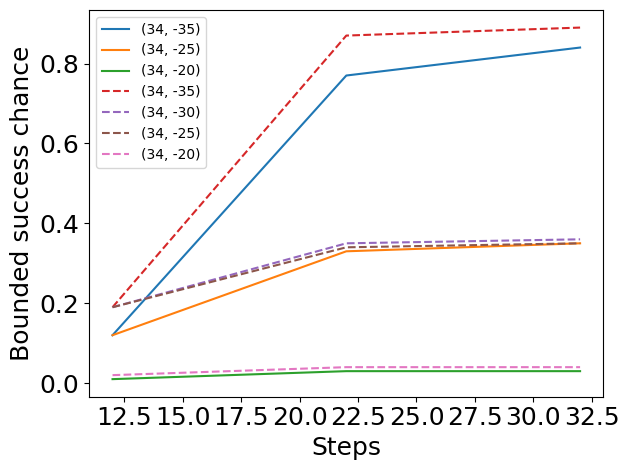

In [ ]:
def plot_df(df, dashed = False):
    df_visual_grouped = df.groupby(['m0','m2'])
    result_dict = {}
    for g in df_visual_grouped.groups.keys():
        r = tuple([round(h,2) for h in df_visual_grouped.get_group(g)['Result'].values])
        if r in result_dict:
            result_dict[r].append(g)
        else:
            result_dict[r] = [g]

    for k in result_dict:
        g = result_dict[k]
        max_m0 = max(h[0] for h in result_dict[k])
        max_m2 = max(h[1] for h in result_dict[k])
        print(k, result_dict[k])
        print(max_m0, max_m2)
        assert((max_m0, max_m2) in result_dict[k])
        if len(set(k)) != 1:
            if dashed:
                plt.plot(df_visual_grouped.get_group((max_m0, max_m2))['m1'], k, label = str((max_m0, max_m2)), linestyle="dashed")
            else:
                plt.plot(df_visual_grouped.get_group((max_m0, max_m2))['m1'], k, label = str((max_m0, max_m2)))

# file_name = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/bounded_steps_gas_min_gas_bpic_17-1.txt"
# df_visual = pd.read_csv(file_name)
# plot_df(df_visual)

# file_name = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/bounded_steps_gas_min_gas_bpic_17-1_1.txt"
# df_visual = pd.read_csv(file_name)
# plot_df(df_visual)

file_name = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/bounded_steps_gas_min_gas_bpic_17-1_2.txt"
df_visual = pd.read_csv(file_name)
plot_df(df_visual)

file_name = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/outputs/bounded_steps_gas_min_gas_bpic_17-2_2.txt"
df_visual = pd.read_csv(file_name)
plot_df(df_visual, dashed=True)

plt.legend(fontsize=10)
plt.xlabel("Steps", fontsize=18)
plt.ylabel("Success probability", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("greps/bounded.png", dpi=300)

## Lost users & repair recommendations

In [51]:
strategy_before = query_before.get_strategy("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props")
strategy_before

['0', 'n0_0', '1', 'n1_0', '2', 'n2_0', '3', 'n3_0', '4', 'n4_0', '5', 'n5_0', '6', 'n6_0', '7', 'n7_0', '8', 'n8_0', '9', 'n9_0', '10', 'n10_0', '11', 'n11_0', '12', 'n12_0', '13', 'n13_0', '14', 'n14_0', '15', 'n15_0', '16', 'n16_0', '17', 'n17_0', '18', 'n18_0', '19', 'n19_0', '20', 'n20_0', '21', 'n21_0', '22', 'n22_0', '23', 'n23_0', '24', 'n24_0', '25', 'n25_0', '26', 'n26_0', '27', 'n27_0', '28', 'n28_0', '29', 'n29_0', '30', 'n30_0', '31', 'n31_0', '32', 'n32_0', '33', 'n33_0', '34', 'n34_0', '35', 'n35_0', '36', 'n36_0', '37', 'n37_0', '38', 'n38_0', '39', 'n39_0', '40', 'n40_0', '41', 'n41_0', '42', 'n42_0', '43', 'n43_0', '44', 'n44_0', '45', 'n45_0', '46', 'n46_0', '47', 'n47_0', '48', 'n48_0', '49', 'n49_0', '50', 'n50_0', '51', 'n51_0', '52', 'n52_0', '53', 'n53_0', '54', 'n54_0', '55', 'n55_0', '56', 'n56_0', '57', 'n57_0', '58', 'n58_0', '59', 'n59_0', '60', 'n60_0', '61', 'n61_0', '62', 'n62_0', '63', 'n63_0', '64', 'n64_0', '65', 'n65_0', '66', 'n66_0', '67', 'n67_0',

{'q0start': 'env',
 'q1companystart': 'A_CreateApplication',
 'q2A_CreateApplication': 'env',
 'q4customerA_CreateApplication': 'A_Submitted',
 'q3companyA_CreateApplication': 'A_Concept',
 'q5A_Concept': 'env',
 'q6A_Submitted': 'env',
 'q7companyA_Concept': 'A_Accepted',
 'q8companyA_Submitted': 'A_Concept',
 'q9A_Accepted': 'env',
 'q10A_Concept': 'env',
 'q11companyA_Accepted': 'O_CreateOffer0',
 'q12companyA_Concept': 'A_Accepted',
 'q13O_CreateOffer0': 'env',
 'q14A_Accepted': 'env',
 'q15companyO_CreateOffer0': 'O_CreateOffer1',
 'q16customerO_CreateOffer0': 'user',
 'q17companyA_Accepted': 'O_CreateOffer0',
 'q18O_CreateOffer1': 'env',
 'q21A_CancelledCUSTOMER': 'env',
 'q22O_Cancelled': 'env',
 'q23O_CreateOffer0': 'env',
 'q24companyO_CreateOffer1': 'sent',
 'q54customerO_CreateOffer1': 'user',
 'q26customerO_Sentmailandonline': 'user',
 'q25companyO_Sentmailandonline': 'A_Validating',
 'q29customerA_CancelledCUSTOMER': 'user',
 'q30companyO_Cancelled': 'O_CreateOffer2',
 'q6

In [52]:
strategy_after = query_after.get_strategy("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props")
strategy_after

['0', 'n0_0', '1', 'n1_0', '2', 'n2_0', '3', 'n3_0', '4', 'n4_0', '5', 'n5_0', '6', 'n6_0', '7', 'n7_0', '8', 'n8_0', '9', 'n9_0', '10', 'n10_0', '11', 'n11_0', '12', 'n12_0', '13', 'n13_0', '14', 'n14_0', '15', 'n15_0', '16', 'n16_0', '17', 'n17_0', '18', 'n18_0', '19', 'n19_0', '20', 'n20_0', '21', 'n21_0', '22', 'n22_0', '23', 'n23_0', '24', 'n24_0', '25', 'n25_0', '26', 'n26_0', '27', 'n27_0', '28', 'n28_0', '29', 'n29_0', '30', 'n30_0', '31', 'n31_0', '32', 'n32_0', '33', 'n33_0', '34', 'n34_0', '35', 'n35_0', '36', 'n36_0', '37', 'n37_0', '38', 'n38_0', '39', 'n39_0', '40', 'n40_0', '41', 'n41_0', '42', 'n42_0', '43', 'n43_0', '44', 'n44_0', '45', 'n45_0', '46', 'n46_0', '47', 'n47_0', '48', 'n48_0', '49', 'n49_0', '50', 'n50_0', '51', 'n51_0', '52', 'n52_0', '53', 'n53_0', '54', 'n54_0', '55', 'n55_0', '56', 'n56_0', '57', 'n57_0', '58', 'n58_0', '59', 'n59_0', '60', 'n60_0', '61', 'n61_0', '62', 'n62_0', '63', 'n63_0', '64', 'n64_0', '65', 'n65_0', '66', 'n66_0', '67', 'n67_0',

{'q0start': 'env',
 'q1companystart': 'A_CreateApplication',
 'q2A_CreateApplication': 'env',
 'q4customerA_CreateApplication': 'A_Submitted',
 'q3companyA_CreateApplication': 'A_Concept',
 'q5A_Concept': 'env',
 'q6A_Submitted': 'env',
 'q7companyA_Concept': 'A_Accepted',
 'q8companyA_Submitted': 'A_Concept',
 'q9A_Accepted': 'env',
 'q10A_Concept': 'env',
 'q11companyA_Accepted': 'O_CreateOffer0',
 'q12companyA_Concept': 'A_Accepted',
 'q13O_CreateOffer0': 'env',
 'q14A_Accepted': 'env',
 'q15companyO_CreateOffer0': 'O_CreateOffer1',
 'q16customerO_CreateOffer0': 'user',
 'q17companyA_Accepted': 'O_CreateOffer0',
 'q18O_CreateOffer1': 'env',
 'q22O_Cancelled': 'env',
 'q21A_CancelledCUSTOMER': 'env',
 'q39TIMEOUT': 'env',
 'q23O_CreateOffer0': 'env',
 'q24companyO_CreateOffer1': 'O_CreateOffer2',
 'q25customerO_CreateOffer1': 'user',
 'q26companyO_Sentmailandonline': 'A_Validating',
 'q29customerA_CancelledCUSTOMER': 'user',
 'q30companyO_Cancelled': 'sent',
 'q31companyO_CreateOffer

In [53]:
def transform_strategy(strategy, g, printer):
    isomophism = nx.vf2pp_isomorphism(printer.g, g, node_label=None)
    strategy_isomorphism = {k[len(isomophism[k].split(": ")[0]):] : ": ".join(isomophism[k].split(": ")[1:]) for k in isomophism}
    parsed_strategy = {isomophism[r] : strategy_isomorphism[strategy[r]] if strategy[r] not in ["env", "user", "company", "sent", "call"] else strategy[r] for r in strategy}
    assert(len(parsed_strategy)==len(strategy))
    return parsed_strategy

def lost_users(g, results_file, strategy):
    start_prob = results_file["q0: start"]
    print(results_file)

    lost_users_dict = {}
    total_lost_users_dict = {}
    for s in strategy:
        print(s)
        assert s in g
        next_states = [t for t in g[s] if g[s][t]['action'] == strategy[s]]

        outgoing_users = sum([len(g[s][t]['trace_indices']) for t in next_states])
        assert(next_states)
        
        total_lost_users = 0
        for t in next_states:
            action_outcome_cost = len(g[s][t]['trace_indices']) * abs(round(results_file[s],4)-round(results_file[t],4)) #* g[s][t]['prob_weight']
            lost_users_dict[(s,t)] = action_outcome_cost

            total_lost_users += action_outcome_cost

            if total_lost_users!= 0:
                print(s, t, len(g[s][t]['trace_indices']), "*", (round(results_file[s],4), round(results_file[t],4)))
                print(action_outcome_cost)
                
        if total_lost_users != 0:
            print("total", total_lost_users)
            total_lost_users_dict[s] = total_lost_users
    total = sum(total_lost_users_dict.values())
    print("total", total)
    for k in (sorted( ((v,k) for k,v in total_lost_users_dict.items()), reverse=True)):
        print(k, k[0]/total)
    print(sorted(lost_users_dict.values(), reverse=True))
    return lost_users_dict

lost_users_dict_before = lost_users(g_before, get_probs_file(results_file_before, g_before, printer_before), transform_strategy(strategy_before, g_before, printer_before))

{'q0: start': 0.8865074490124265, 'q1: companystart': 0.8865074490124265, 'q2: A_CreateApplication': 0.886508297569364, 'q4: customerA_CreateApplication': 0.8867864323315477, 'q3: companyA_CreateApplication': 0.8860121197553523, 'q5: A_Concept': 0.8860129640179052, 'q6: A_Submitted': 0.8867864869849466, 'q7: companyA_Concept': 0.8860129640179052, 'q8: companyA_Submitted': 0.8867864869849466, 'q9: A_Accepted': 0.8860129997819536, 'q10: A_Concept': 0.8867873317796326, 'q11: companyA_Accepted': 0.8860129997819536, 'q12: companyA_Concept': 0.8867873317796326, 'q13: O_CreateOffer0': 0.8860135511664289, 'q14: A_Accepted': 0.8867873674735474, 'q15: companyO_CreateOffer0': 0.8890792158232009, 'q16: customerO_CreateOffer0': 0.3829890754010747, 'q17: companyA_Accepted': 0.8867873674735474, 'q19: O_Sentmailandonline': 0.084019165455791, 'q20: O_Sentonlineonly': 0.2286040180957565, 'q18: O_CreateOffer1': 0.8890792389992226, 'q21: A_CancelledCUSTOMER': 0, 'q22: O_Cancelled': 0.8248996614112286, 'q2

In [58]:
import plotly.graph_objects as go

def flatten(d, l):
      print("call", d, l)
      for e in d:
            l.append(e)
            if 'contraction' in d[e]:
                  print("flatten", d)
                  flatten(d[e]['contraction'], l)
      return l

def reduced_sankey_diagram(g, results_file, strategy, lost_users_dict):
      g = copy.deepcopy(g)
      print(strategy.keys())
      g = g.subgraph(strategy.keys()) # consider only nodes seen in strategy
      g = reduce_graph(g, results_file)
      color_map = compute_color_map(g, results_file)
      
      for s in g:
            print(s, g.nodes[s])
      print()

      d = nx.get_node_attributes(g, "contraction")
      reduction_mapping = {}
      print("attr", d)
      for k in d:
            reduction_mapping[k] = flatten(d[k], [])
      print(reduction_mapping)
                             
      node_list = list(g.nodes())
      print("Node_list", node_list)
      print(len(node_list))
      node_dict = {node_list[i] : i for i in range(len(node_list))}

      print("dict", lost_users_dict)

      edge_list = []
      value_list = []
      for e in [e for e in lost_users_dict if lost_users_dict[e] != 0]:
            print(e)
            if e[0] in node_list:
                  s = e[0]
            else:
                  s = None
                  for h in reduction_mapping:
                        if e[0] in reduction_mapping[h]:
                              s = h
                  assert s
            if e[1] in node_list:
                  t = e[1]
            else:
                  t = None
                  for h in reduction_mapping:
                        if e[1] in reduction_mapping[h]:
                              t = h
                  assert t
            edge_list.append((s,t))
            value_list.append(lost_users_dict[e])


      #edge_list = [[e for e in lost_users_dict if lost_users_dict[e] != 0]]
      #edge_list = [e for e in g.edges() if e[0] in node_list and e[1] in node_list]
      
      print("edge list", edge_list)

      # value_list = []
      # for e in edge_list:
      #       if e[0] in node_list and e[1] in node_list:
      #             value_list.append(lost_users_dict[e])
      #       print(e)
      #       print(len(g[e[0]][e[1]]['trace_indices']) , round(results_file[e[0]],5), round(results_file[e[1]],5))
      # print(sorted([len(g[e[0]][e[1]]['trace_indices'])  * abs(round(results_file[e[0]],5)-round(results_file[e[1]],5)) for e in edge_list], reverse = True))
      # print(sum([len(g[e[0]][e[1]]['trace_indices'])  * abs(round(results_file[e[0]],5)-round(results_file[e[1]],5)) for e in edge_list]))

      print("sum", sum(value_list))

      #print([len(g.edges[e]['trace_indices']) for e in edge_list])
      labels = []
      print(reduction_mapping)
      for s in node_list:
            print(s)
            if s not in reduction_mapping or s in lost_users_dict:
                  print("not")
                  label = str(s).split(": ")[1].replace("LONG", "").replace("SHORT", "").replace("W_", "").replace("Callincompletefiles", 'Call incomplete files')
                  labels.append(label)
            elif any(["start" in h for h in reduction_mapping[s]]):
                  labels.append("Start")
            elif any(["q30" in h for h in reduction_mapping[s]]) or "q30" in s:
                  labels.append("Sent (mail and online)")
            elif any(["q23" in h for h in reduction_mapping[s]]) or "q23" in s:
                  labels.append("Create Offer 0")
            elif any(["q13" in h for h in reduction_mapping[s]]) or "q13" in s:
                  labels.append("Create Offer 0")
            elif results_file[s] == 1:#any(["positive" in h for h in reduction_mapping[s]]):
                  labels.append("succ")
            elif results_file[s] == 0: #any(["negative" in h for h in reduction_mapping[s]]):
                  labels.append("unsucc")
            else:
                  # s is in reduction_mapping and not in lost_users_dict
                  print("found", s)
                  labels.append("")
                  #labels.append("C"+str(s).split(": ")[0])
      print(labels)

      fig = go.Figure(data=[go.Sankey(
      node = dict(
          pad = 5,
          thickness = 30,
          line = dict(color = "black", width = 0.5),
          label = labels,#[str(s) if "start" not in  for s in node_list],
          color = [color_map[s] for s in node_list],
          align = "right"
      ),
      link = dict(
          source = [node_dict[e[0]] for e in edge_list],
          target = [node_dict[e[1]] for e in edge_list],
          value = value_list,#[len(g[e[0]][e[1]]['trace_indices']) * abs(round(results_file[e[0]],5)-round(results_file[e[1]],5)) for e in edge_list],
          arrowlen=15,
          #[len(g.edges[e]['trace_indices']) for e in edge_list]
      ))])
      fig.update_layout(
        font=dict(size = 30)
    )
      fig.write_image("out/before_sankey.png")
      fig.show()


reduced_sankey_diagram(g_before, get_probs_file(results_file_before, g_before, printer_before), transform_strategy(strategy_before, g_before, printer_before), lost_users_dict_before)

dict_keys(['q0: start', 'q1: companystart', 'q2: A_CreateApplication', 'q4: customerA_CreateApplication', 'q3: companyA_CreateApplication', 'q5: A_Concept', 'q6: A_Submitted', 'q7: companyA_Concept', 'q8: companyA_Submitted', 'q9: A_Accepted', 'q10: A_Concept', 'q11: companyA_Accepted', 'q12: companyA_Concept', 'q13: O_CreateOffer0', 'q14: A_Accepted', 'q15: companyO_CreateOffer0', 'q16: customerO_CreateOffer0', 'q17: companyA_Accepted', 'q18: O_CreateOffer1', 'q21: A_CancelledCUSTOMER', 'q22: O_Cancelled', 'q23: O_CreateOffer0', 'q24: companyO_CreateOffer1', 'q54: customerO_CreateOffer1', 'q26: customerO_Sentmailandonline', 'q25: companyO_Sentmailandonline', 'q29: customerA_CancelledCUSTOMER', 'q30: companyO_Cancelled', 'q68: customerO_Cancelled', 'q31: companyO_CreateOffer0', 'q33: O_Sentmailandonline', 'q32: O_CreateOffer2', 'q34: A_Validating', 'q82: O_CreateOffer3', 'q39: TIMEOUT', 'q86: O_Cancelled', 'q43: companyO_CreateOffer2', 'q44: companyA_Validating', 'q52: customerTIMEOUT'

In [59]:
lost_users_dict_after = lost_users(g_after, get_probs_file(results_file_after, g_after, printer_after), transform_strategy(strategy_after, g_after, printer_after))

{'q0: start': 0.9166362285809062, 'q1: companystart': 0.916636608144698, 'q2: A_CreateApplication': 0.916636608144698, 'q4: customerA_CreateApplication': 0.915332166845689, 'q3: companyA_CreateApplication': 0.919068427247554, 'q5: A_Concept': 0.919068427247554, 'q6: A_Submitted': 0.915332166845689, 'q7: companyA_Concept': 0.9190687738019208, 'q8: companyA_Submitted': 0.9153322617016352, 'q9: A_Accepted': 0.9190687738019208, 'q10: A_Concept': 0.9153322617016352, 'q11: companyA_Accepted': 0.9190688188907232, 'q12: companyA_Concept': 0.9153326050313912, 'q13: O_CreateOffer0': 0.9190688188907232, 'q14: A_Accepted': 0.9153326050313912, 'q15: companyO_CreateOffer0': 0.9246683141825895, 'q16: customerO_CreateOffer0': 0.0704207718909551, 'q17: companyA_Accepted': 0.9153326507057684, 'q19: O_Sentmailandonline': 0.1079845575114114, 'q20: O_Sentonlineonly': 0.1227195021120721, 'q18: O_CreateOffer1': 0.9246683141825895, 'q22: O_Cancelled': 0.4084404769675395, 'q21: A_CancelledCUSTOMER': 0, 'q39: T

In [61]:
import plotly.graph_objects as go

def flatten(d, l):
      print("call", d, l)
      for e in d:
            l.append(e)
            if 'contraction' in d[e]:
                  print("flatten", d)
                  flatten(d[e]['contraction'], l)
      return l

def reduced_sankey_diagram(g, results_file, strategy, lost_users_dict):
      g = copy.deepcopy(g)
      print(strategy.keys())
      g = g.subgraph(strategy.keys()) # consider only nodes seen in strategy
      g = reduce_graph(g, results_file)
      color_map = compute_color_map(g, results_file)
      
      for s in g:
            print(s, g.nodes[s])
      print()

      d = nx.get_node_attributes(g, "contraction")
      reduction_mapping = {}
      print("attr", d)
      for k in d:
            reduction_mapping[k] = flatten(d[k], [])
      print(reduction_mapping)
                             
      node_list = list(g.nodes())
      print("Node_list", node_list)
      print(len(node_list))
      node_dict = {node_list[i] : i for i in range(len(node_list))}

      print("dict", lost_users_dict)

      edge_list = []
      value_list = []
      for e in [e for e in lost_users_dict if lost_users_dict[e] != 0]:
            print(e)
            if e[0] in node_list:
                  s = e[0]
            else:
                  s = None
                  for h in reduction_mapping:
                        if e[0] in reduction_mapping[h]:
                              s = h
                  assert s
            if e[1] in node_list:
                  t = e[1]
            else:
                  t = None
                  for h in reduction_mapping:
                        if e[1] in reduction_mapping[h]:
                              t = h
                  assert t
            print("value from", s, "to", t, "with", lost_users_dict[e])
            edge_list.append((s,t))
            value_list.append(lost_users_dict[e])


      #edge_list = [[e for e in lost_users_dict if lost_users_dict[e] != 0]]
      #edge_list = [e for e in g.edges() if e[0] in node_list and e[1] in node_list]
      
      print("edge list", edge_list)

      # value_list = []
      # for e in edge_list:
      #       if e[0] in node_list and e[1] in node_list:
      #             value_list.append(lost_users_dict[e])
      #       print(e)
      #       print(len(g[e[0]][e[1]]['trace_indices']) , round(results_file[e[0]],5), round(results_file[e[1]],5))
      # print(sorted([len(g[e[0]][e[1]]['trace_indices'])  * abs(round(results_file[e[0]],5)-round(results_file[e[1]],5)) for e in edge_list], reverse = True))
      # print(sum([len(g[e[0]][e[1]]['trace_indices'])  * abs(round(results_file[e[0]],5)-round(results_file[e[1]],5)) for e in edge_list]))

      print("sum", sum(value_list))

      #print([len(g.edges[e]['trace_indices']) for e in edge_list])
      labels = []
      print(reduction_mapping)
      for s in node_list:
            print(s)
            if s not in reduction_mapping or s in lost_users_dict:
                  print("not")
                  label = str(s).split(": ")[1].replace("LONG", "").replace("SHORT", "").replace("W_", "").replace("Callincompletefiles", 'Call incomplete files')
                  labels.append(label)
            elif any(["start" in h for h in reduction_mapping[s]]):
                  labels.append("Start")
            elif any(["q64" in h for h in reduction_mapping[s]]) or "q64" in s:
                  labels.append("Sent (mail and online)")
            elif any(["q23" in h for h in reduction_mapping[s]]) or "q23" in s:
                  labels.append("Create Offer 0")
            elif any(["q13" in h for h in reduction_mapping[s]]) or "q13" in s:
                  labels.append("Create Offer 0")
            elif any(["q42" in h for h in reduction_mapping[s]]) or "q42" in s:
                  labels.append("Create Offer 1")
            elif any(["q32" in h for h in reduction_mapping[s]]) or "q42" in s:
                  labels.append("Create Offer 2")
            elif results_file[s] == 1:#any(["positive" in h for h in reduction_mapping[s]]):
                  labels.append("succ")
            elif results_file[s] == 0: #any(["negative" in h for h in reduction_mapping[s]]):
                  labels.append("unsucc")
            else:
                  # s is in reduction_mapping and not in lost_users_dict
                  print("found", s)
                  labels.append("")
                  #labels.append("C"+str(s).split(": ")[0])
      print(labels)

      fig = go.Figure(data=[go.Sankey(
      node = dict(
          pad = 10,
          thickness = 30,
          line = dict(color = "black", width = 0.5),
          label = labels,#[str(s) if "start" not in  for s in node_list],
          color = [color_map[s] for s in node_list],
          align = "right"
      ),
      link = dict(
          source = [node_dict[e[0]] for e in edge_list],
          target = [node_dict[e[1]] for e in edge_list],
          value = value_list,#[len(g[e[0]][e[1]]['trace_indices']) * abs(round(results_file[e[0]],5)-round(results_file[e[1]],5)) for e in edge_list],
          arrowlen=15,
          #[len(g.edges[e]['trace_indices']) for e in edge_list]
      ))])
      fig.update_layout(
        font=dict(size = 30)
    )
      fig.write_image("out/after_sankey.png")
      fig.show()

reduced_sankey_diagram(g_after, get_probs_file(results_file_after, g_after, printer_after),  transform_strategy(strategy_after, g_after, printer_after), lost_users_dict_after)

dict_keys(['q0: start', 'q1: companystart', 'q2: A_CreateApplication', 'q4: customerA_CreateApplication', 'q3: companyA_CreateApplication', 'q5: A_Concept', 'q6: A_Submitted', 'q7: companyA_Concept', 'q8: companyA_Submitted', 'q9: A_Accepted', 'q10: A_Concept', 'q11: companyA_Accepted', 'q12: companyA_Concept', 'q13: O_CreateOffer0', 'q14: A_Accepted', 'q15: companyO_CreateOffer0', 'q16: customerO_CreateOffer0', 'q17: companyA_Accepted', 'q18: O_CreateOffer1', 'q22: O_Cancelled', 'q21: A_CancelledCUSTOMER', 'q39: TIMEOUT', 'q23: O_CreateOffer0', 'q24: companyO_CreateOffer1', 'q25: customerO_CreateOffer1', 'q26: companyO_Sentmailandonline', 'q29: customerA_CancelledCUSTOMER', 'q30: companyO_Cancelled', 'q31: companyO_CreateOffer0', 'q32: O_CreateOffer2', 'q35: A_Validating', 'q64: O_Sentmailandonline', 'q42: O_CreateOffer1', 'q44: companyO_CreateOffer2', 'q87: customerO_CreateOffer2', 'q47: companyA_Validating', 'q48: customerA_Validating', 'q55: customerTIMEOUT', 'q57: companyO_CreateO

In [57]:
def total_lost_users(g):
    for s in g:
        if "negative" in s:
            print("neg", sum([len(set(g.edges[e]['trace_indices'])) for e in g.in_edges(s)]))
        if "positive" in s:
            print("pos", sum([len(set(g.edges[e]['trace_indices'])) for e in g.in_edges(s)]))

def negative_outcomes(g, results_file):
    for s in g:
        if results_file[s] == 0:
            for e in g.in_edges(s):
                print(e, g.edges[e])
            print()

total_lost_users(g_before)
#negative_outcomes(g_before, get_probs_file(results_file_before, g_before, printer_before))
negative_outcomes(g_after, get_probs_file(results_file_after, g_after, printer_after))

neg 2907
pos 2608
('q16: customerO_CreateOffer0', 'q21: A_CancelledCUSTOMER') {'action': 'user', 'prob_weight': 0.7931034482758621, 'controllable': False, 'count': 23, 'gas': -24.2, 'trace_indices': [5112, 5113, 5114, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5760, 5762, 5763, 6131, 6132, 6133, 6684, 6685, 6774, 6775, 6776]}
('q27: customerO_Sentmailandonline', 'q21: A_CancelledCUSTOMER') {'action': 'user', 'prob_weight': 0.176056338028169, 'controllable': False, 'count': 25, 'gas': -24.2, 'trace_indices': [1161, 1307, 1315, 1349, 1395, 1487, 1544, 1838, 3261, 3771, 3783, 3784, 3799, 3803, 4347, 4396, 4398, 4601, 4732, 4737, 5076, 5080, 5087, 6489, 6490]}
('q28: customerO_Sentonlineonly', 'q21: A_CancelledCUSTOMER') {'action': 'user', 'prob_weight': 0.25, 'controllable': False, 'count': 3, 'gas': -24.2, 'trace_indices': [3761, 3762, 6155]}
('q50: customerW_CallafteroffersLONG', 'q21: A_CancelledCUSTOMER') {'action': 'user', 'prob_weight': 0.15, 'controllable': False, 'count